# MSIS 5753 - Mini Project 2
## Team 13
### Members
- Brock Bennett
- Isabella Liberman
- John Ramirez
- Nathan Zlomke


# Import Findspark, and Import Necessary Libraries

In [1]:
# Import Findsparkd
import findspark
findspark.init()
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col, asc,desc
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

# Initiate a spark session

In [2]:
spark=SparkSession.builder \
.master ("local[*]")\
.appName("week3")\
.getOrCreate()
sc=spark.sparkContext
sqlContext=SQLContext(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/29 13:18:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Users/nathanzlomke/Documents/spark-3.3.3-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

### The objective of the classification is to identify clients who will subscribe (yes/no) for a term deposit. (Variable y: Target function).

#### Conduct EDA to identify relationships, trends in data. 
For example: correlations, bivariate analysis of target versus input variables, facts, univariate patterns, missing data

In [4]:
#Read in file
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("/Users/nathanzlomke/Downloads/XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [5]:
pd.set_option('display.max_columns', None)
df.toPandas().head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [7]:
df = df.withColumnRenamed('emp.var.rate','emp_var_rate')
df = df.withColumnRenamed('cons.price.idx','cons_price_idx')
df = df.withColumnRenamed('cons.conf.idx','cons_conf_idx')
df = df.withColumnRenamed('nr.employed','nr_employed')

#### Numerical Statistics

In [8]:
#Statistics for numerical features
numeric_features = [t[0] for t in df.dtypes if (t[1] == 'int') or(t[1] =='double')]
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,5.045


#### Categorical Statistics

In [9]:
categorical_features = list(set(df.columns) - set(numeric_features))

In [10]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

# Assuming 'categorical_features' is a list of categorical column names
categorical_stats = []

for feature in categorical_features:
    distinct_count = df.select(feature).distinct().count()
    mode = df.groupBy(feature).count().orderBy(col("count").desc()).first()[feature]
    frequency_counts = df.groupBy(feature).count().orderBy(F.col('count').desc())
    percentage_counts = frequency_counts.groupBy(feature).agg(F.count(feature).alias('count'), (F.count(feature) / df.count() * 100).alias('percentage')).orderBy(F.col('count').desc())

    categorical_stats.append({
        'feature': feature,
        'distinct_count': distinct_count,
        'mode': mode,
        'categ_freq': frequency_counts.collect()
        #,'categ_percntg':percentage_counts.collect()
    })

    
    # Calculate percentage directly without modifying the DataFrame
    
    # Now you can use percentage_counts as needed, and 'percentage' is a calculated element


In [11]:
#Percentage isn't calculated correctly, and want to find how to make embedded values look more presentable...i.e., tabular
pd.set_option('display.max_colwidth', None)
categorical_stats_df = pd.DataFrame(categorical_stats)
categorical_stats_df

,feature,distinct_count,mode,categ_freq
0,job,12,admin.,"[(admin., 10422), (blue-collar, 9254), (technician, 6743), (services, 3969), (management, 2924), (retired, 1720), (entrepreneur, 1456), (self-employed, 1421), (housemaid, 1060), (unemployed, 1014), (student, 875), (unknown, 330)]"
1,default,3,no,"[(no, 32588), (unknown, 8597), (yes, 3)]"
2,marital,4,married,"[(married, 24928), (single, 11568), (divorced, 4612), (unknown, 80)]"
3,day_of_week,5,thu,"[(thu, 8623), (mon, 8514), (wed, 8134), (tue, 8090), (fri, 7827)]"
4,housing,3,yes,"[(yes, 21576), (no, 18622), (unknown, 990)]"
5,education,8,university.degree,"[(university.degree, 12168), (high.school, 9515), (basic.9y, 6045), (professional.course, 5243), (basic.4y, 4176), (basic.6y, 2292), (unknown, 1731), (illiterate, 18)]"
6,poutcome,3,nonexistent,"[(nonexistent, 35563), (failure, 4252), (success, 1373)]"
7,y,2,no,"[(no, 36548), (yes, 4640)]"
8,loan,3,no,"[(no, 33950), (yes, 6248), (unknown, 990)]"
9,contact,2,cellular,"[(cellular, 26144), (telephone, 15044)]"


### At first glance, doesn't appear any missing variables, perform more EDA and see

### Any imputation necessary?

### Target Variable Distribution

In [12]:
df.groupBy('y').count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



In [13]:
4640/36548

0.126956331399803

(Mental note:  Isn't there a certain case in machine learning when you are attempting to predict a minority case?  like fraud or spam cases?)

In [14]:
len(df.columns)

21

### Histograms

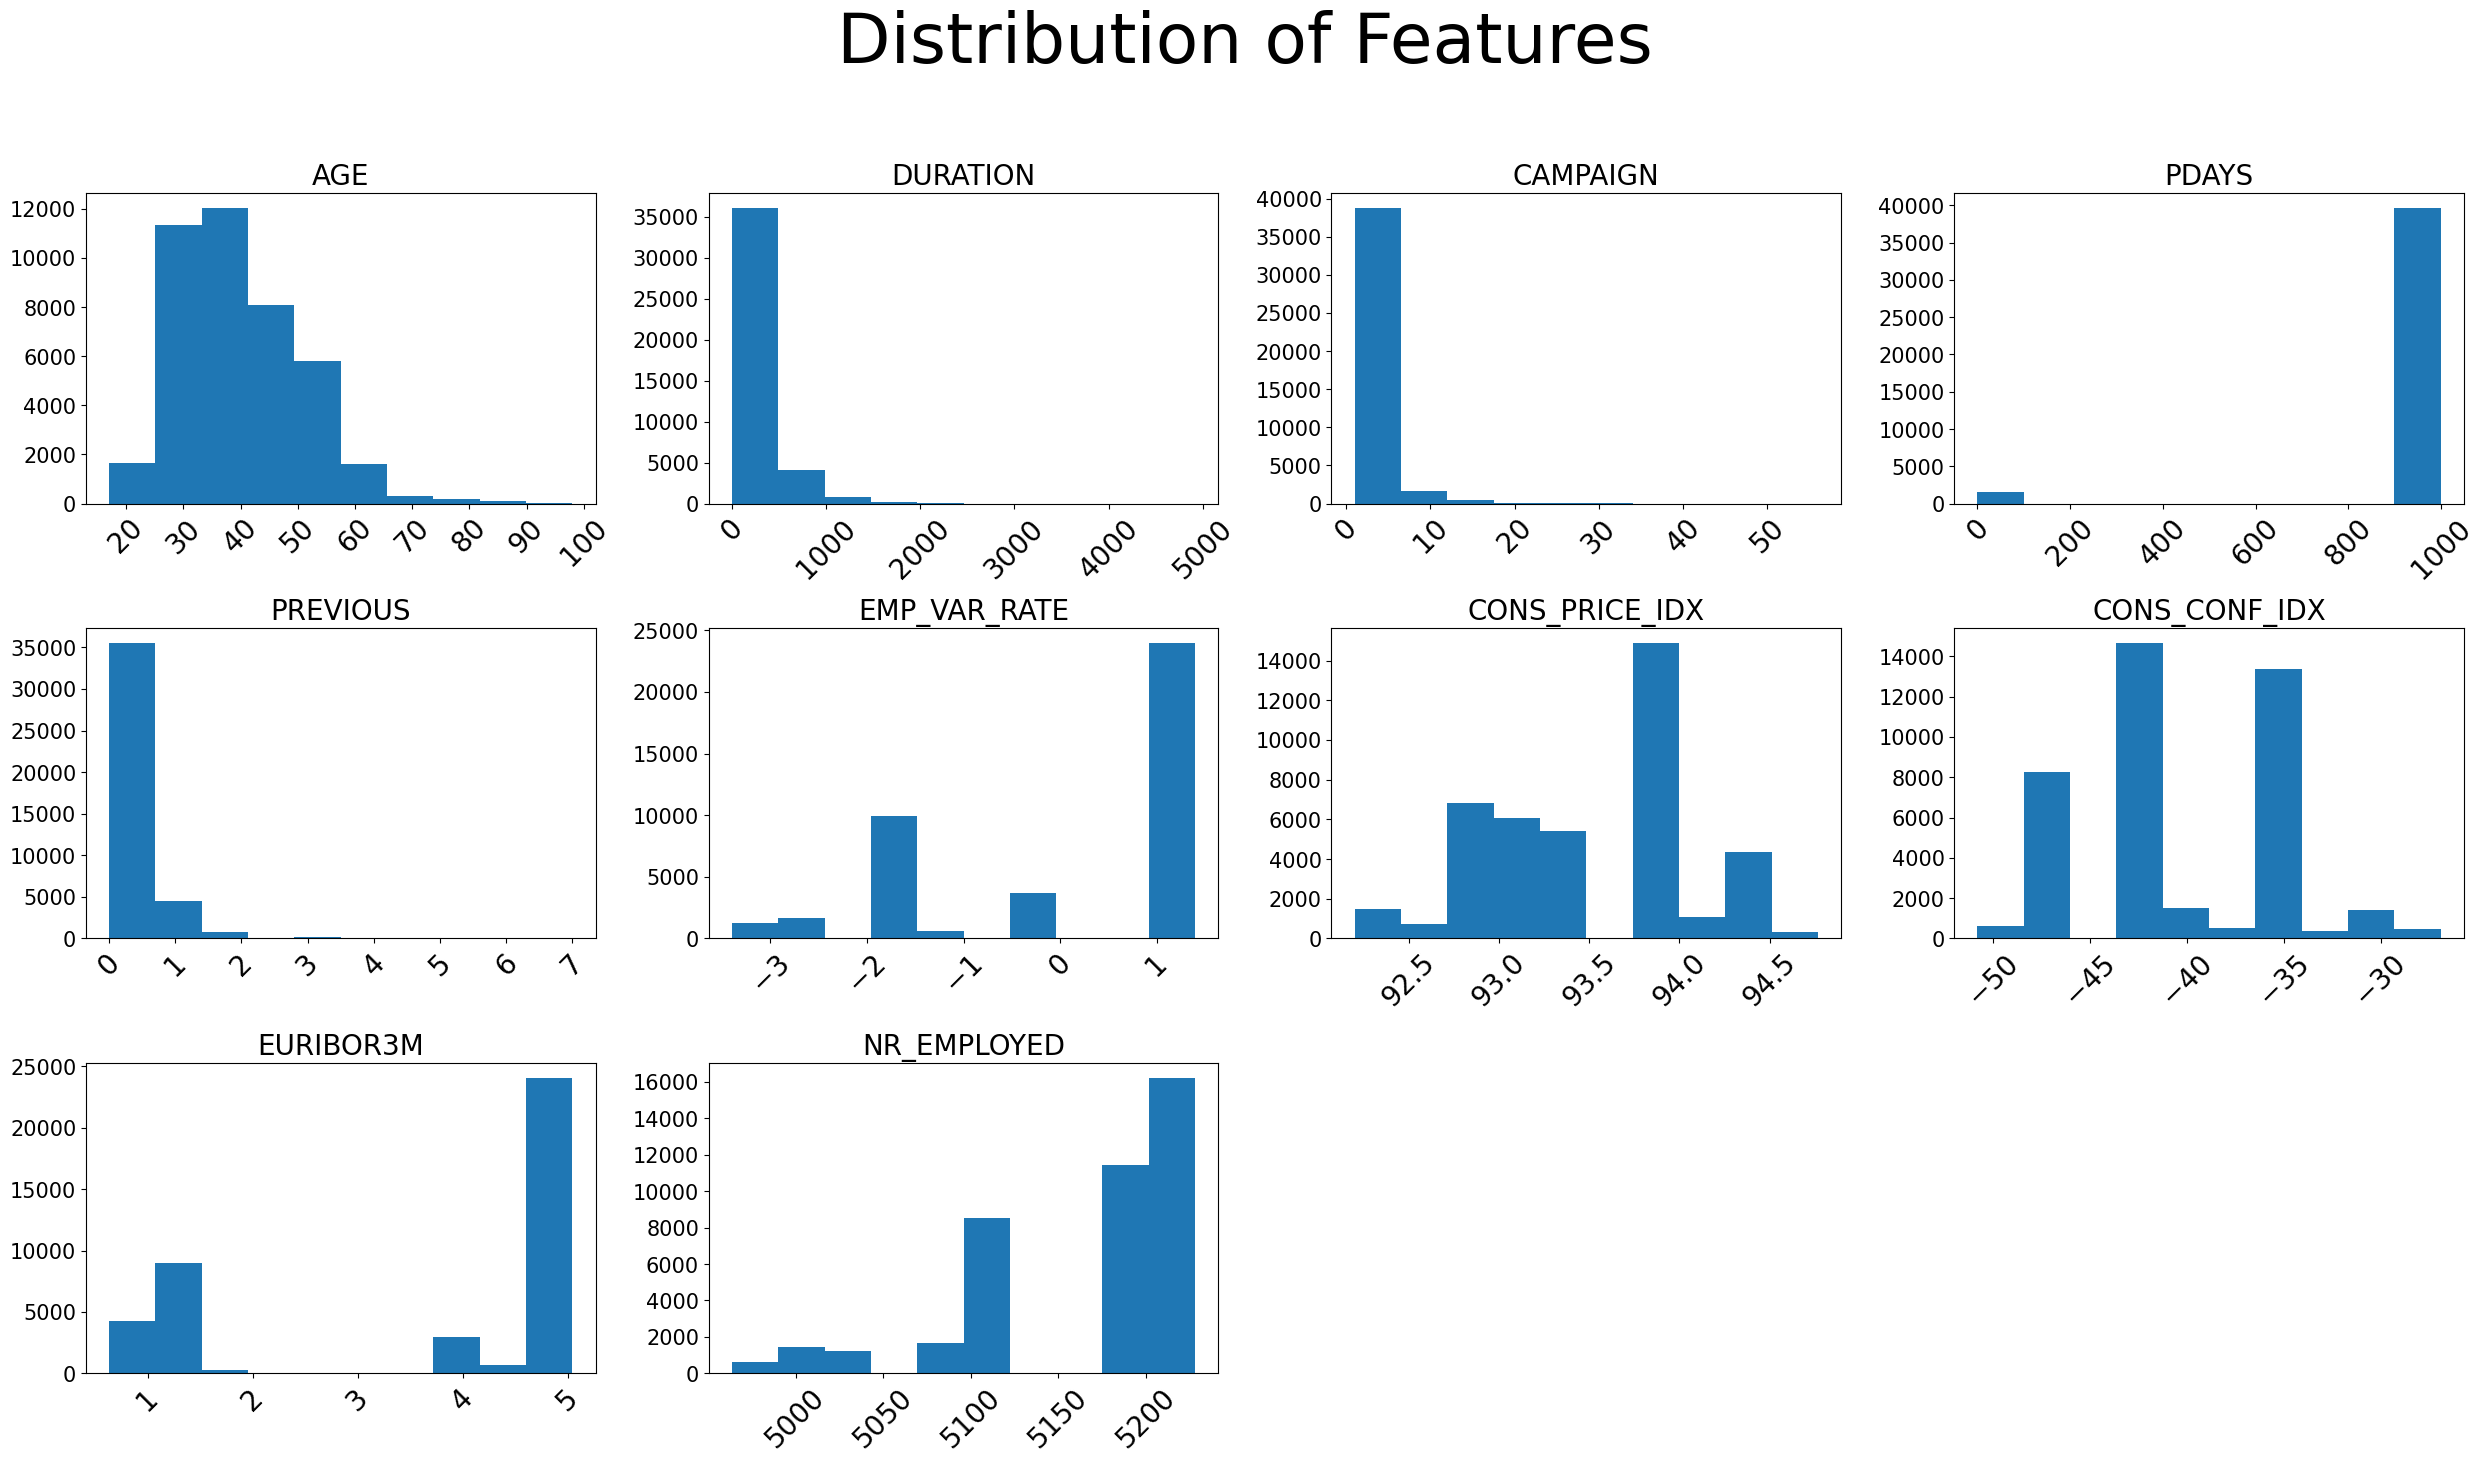

In [15]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,len(df.columns)+1)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

### Feature Engineering / Transformations

I think it makes sense to bin `Pdays` <br>
Try transforming others to see if their distribution changes

In [16]:
def udf_Pdays(pdays):
      if (pdays <= 5):
        return '25 and Under'
      elif (pdays > 5 and pdays <= 10):
        return '26 to 50'
      elif (pdays > 10 and pdays <= 15):
        return '51 to 75'
      elif (pdays > 15):
        return 'Over 76'
      else: return 'N/A'

pdays_udf = udf(udf_Pdays)
df=df.withColumn("pdays_binned", pdays_udf('pdays'))
#df.toPandas().head()

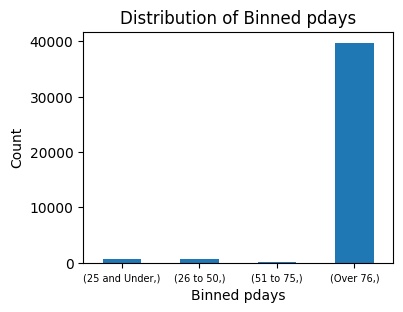

In [17]:
# Assuming df is your Pandas DataFrame
df.select('pdays_binned').toPandas().value_counts().sort_index().plot(kind='bar', figsize=(4, 3))

plt.title('Distribution of Binned pdays')
plt.xlabel('Binned pdays')
plt.ylabel('Count')
plt.xticks(rotation=0,fontsize=7)

plt.show()

In [18]:
df = df.drop('pdays')
numeric_features.remove('pdays')
categorical_features.append('pdays_binned')

### Correlation with Target Variable

In [19]:
numeric_features_df = df.select(numeric_features)
num_col_names =numeric_features_df.columns
num_features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(num_features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = num_col_names, num_col_names

corr_df

23/11/29 13:18:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/29 13:18:56 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


,age,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
previous,0.024365,0.020640,-0.079141,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


### Scatterplots

In [20]:
#Have to convert binary target, y, to numerical variable
from pyspark.ml.feature import StringIndexer
df2=df

StringIndexer = StringIndexer()\
                .setInputCol('y')\
                .setOutputCol('y_indexed')
y_indexed_model = StringIndexer.fit(df2)
y_indexed_df = y_indexed_model.transform(df2)
y_indexed_df.toPandas().head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,pdays_binned,y_indexed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 76,0.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 76,0.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 76,0.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 76,0.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 76,0.0


In [21]:
scatter_col = numeric_features + ['y_indexed']
scatter_df = y_indexed_df.select(scatter_col).toPandas()
scatter_df

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y_indexed
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,0.0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,0.0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,0.0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,0.0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,0.0
...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,0,-1.1,94.767,-50.8,1.028,4963.6,1.0
41184,46,383,1,0,-1.1,94.767,-50.8,1.028,4963.6,0.0
41185,56,189,2,0,-1.1,94.767,-50.8,1.028,4963.6,0.0
41186,44,442,1,0,-1.1,94.767,-50.8,1.028,4963.6,1.0


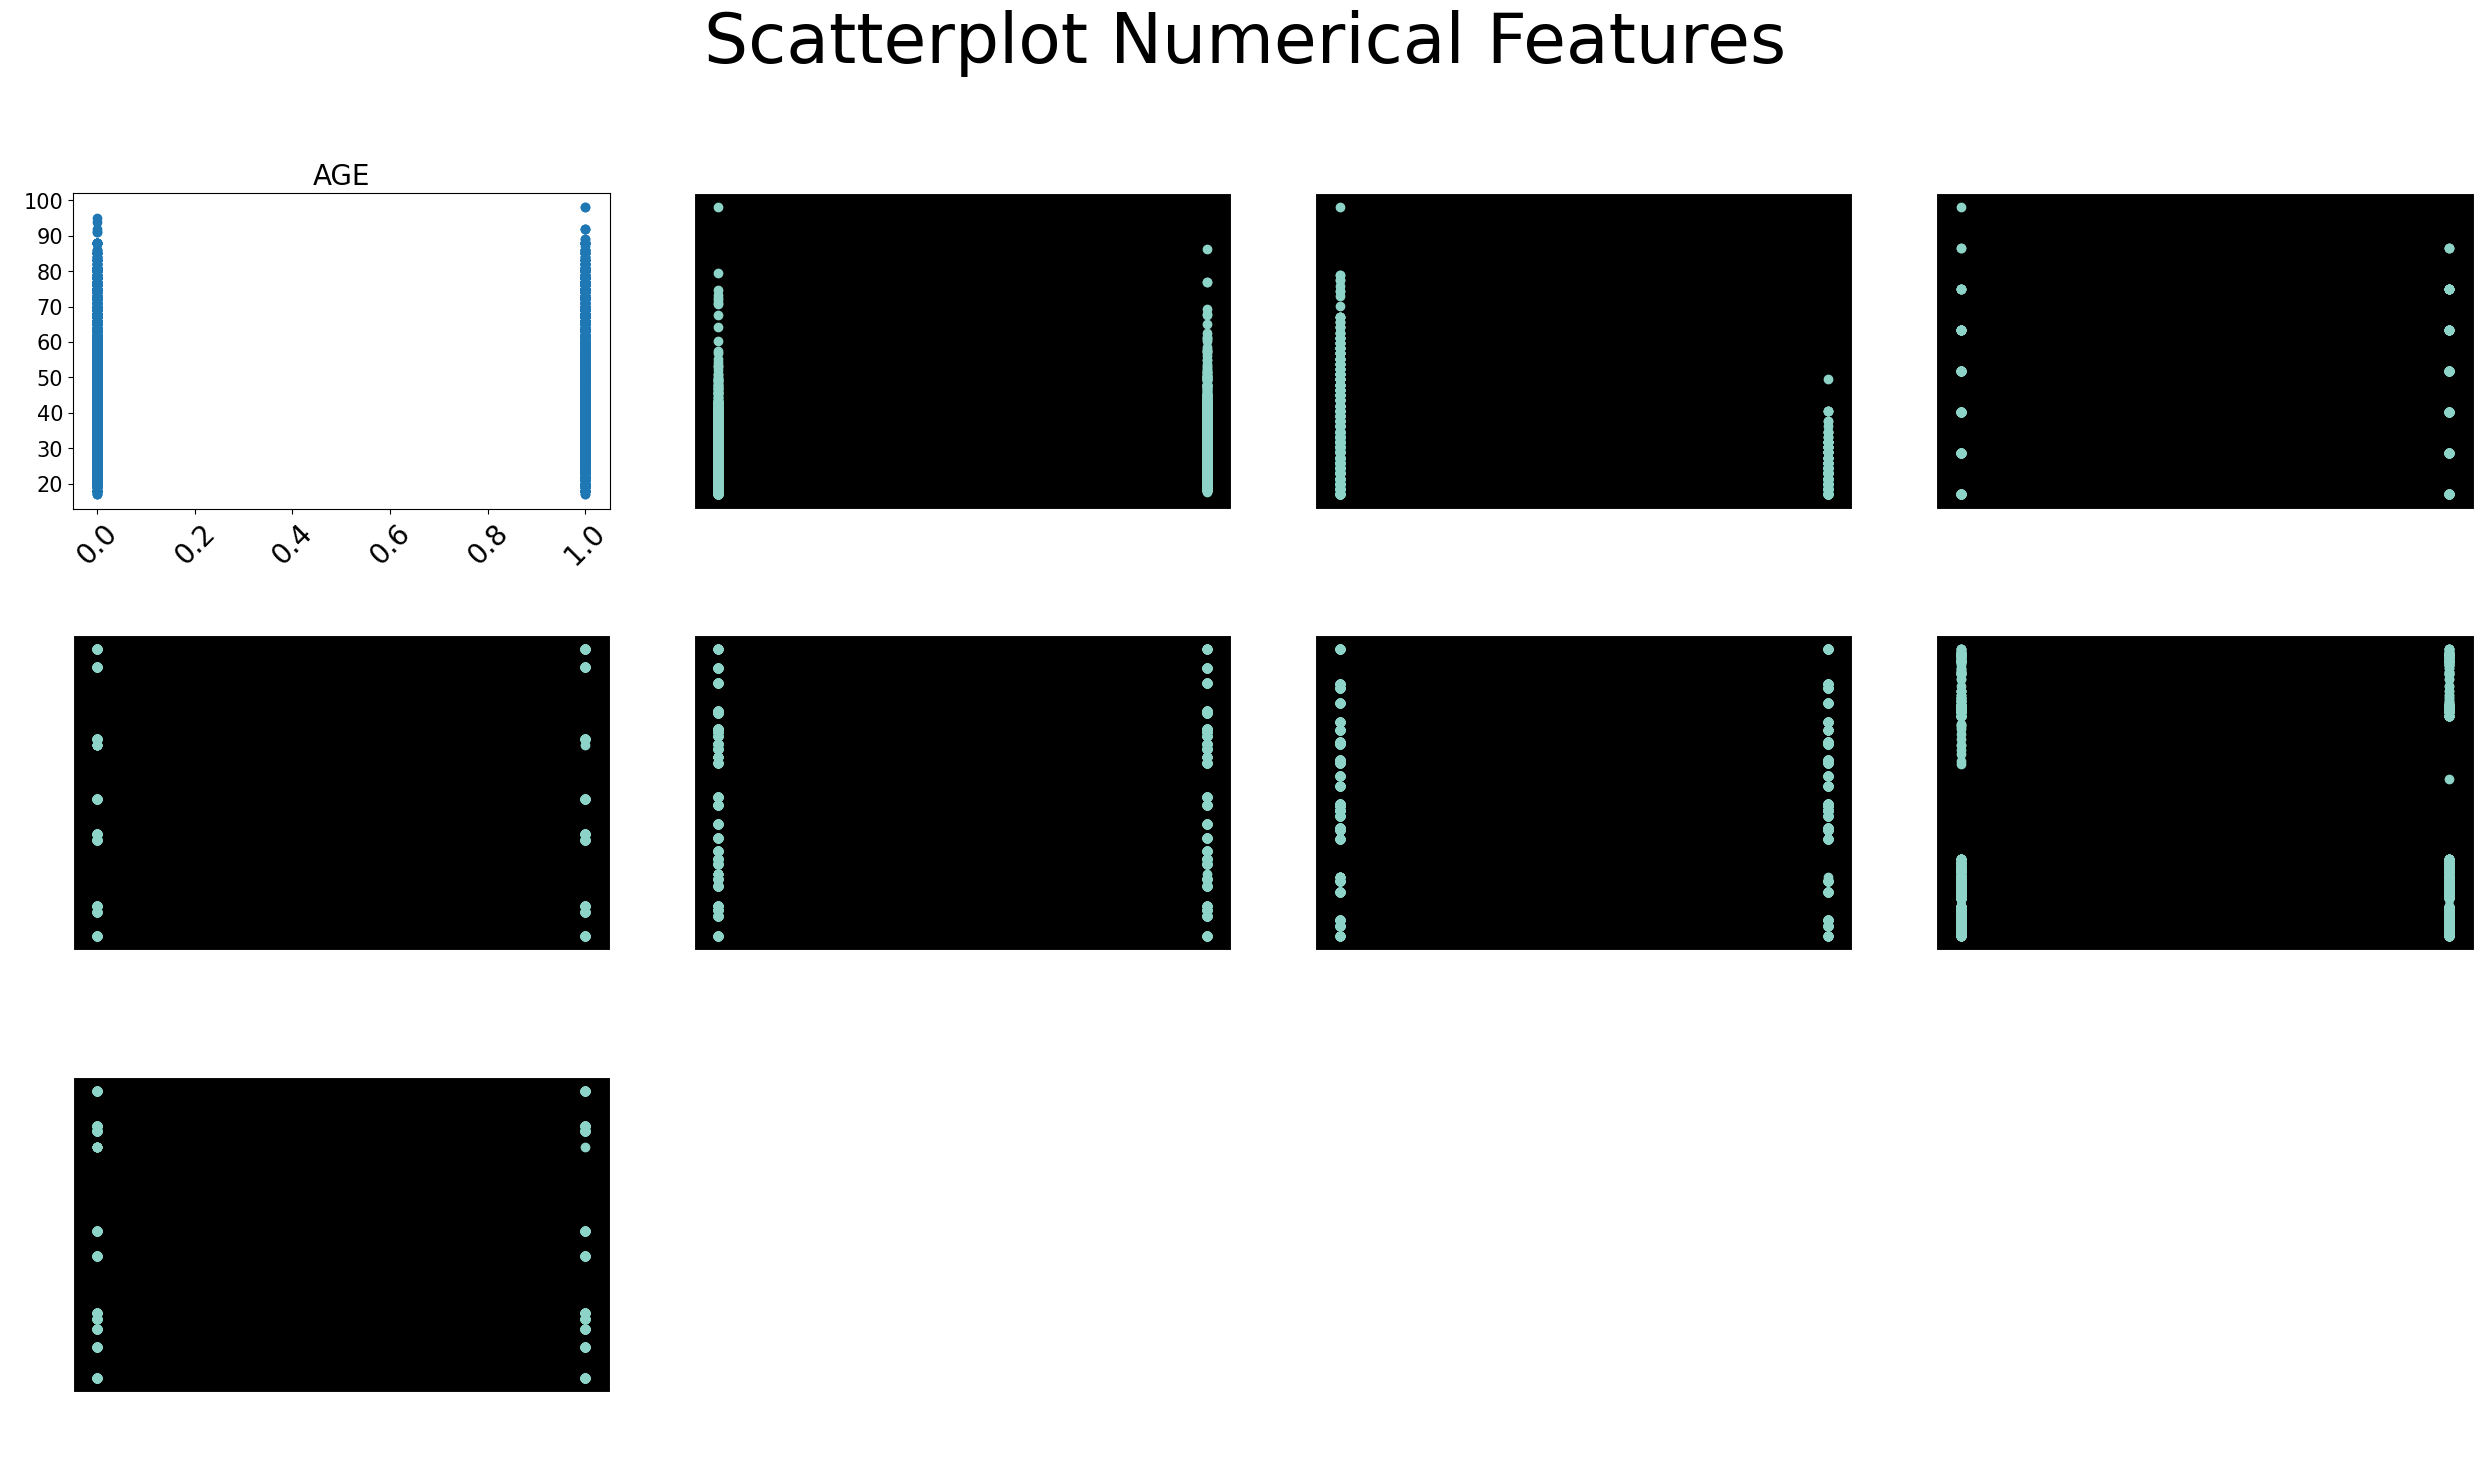

In [22]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Scatterplot Numerical Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(scatter_df.describe().columns, range(1,len(scatter_df.columns))):
    ax = fig.add_subplot(3,4,num)
    ax.scatter(x=scatter_df['y_indexed'], y=scatter_df[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

### Box plots

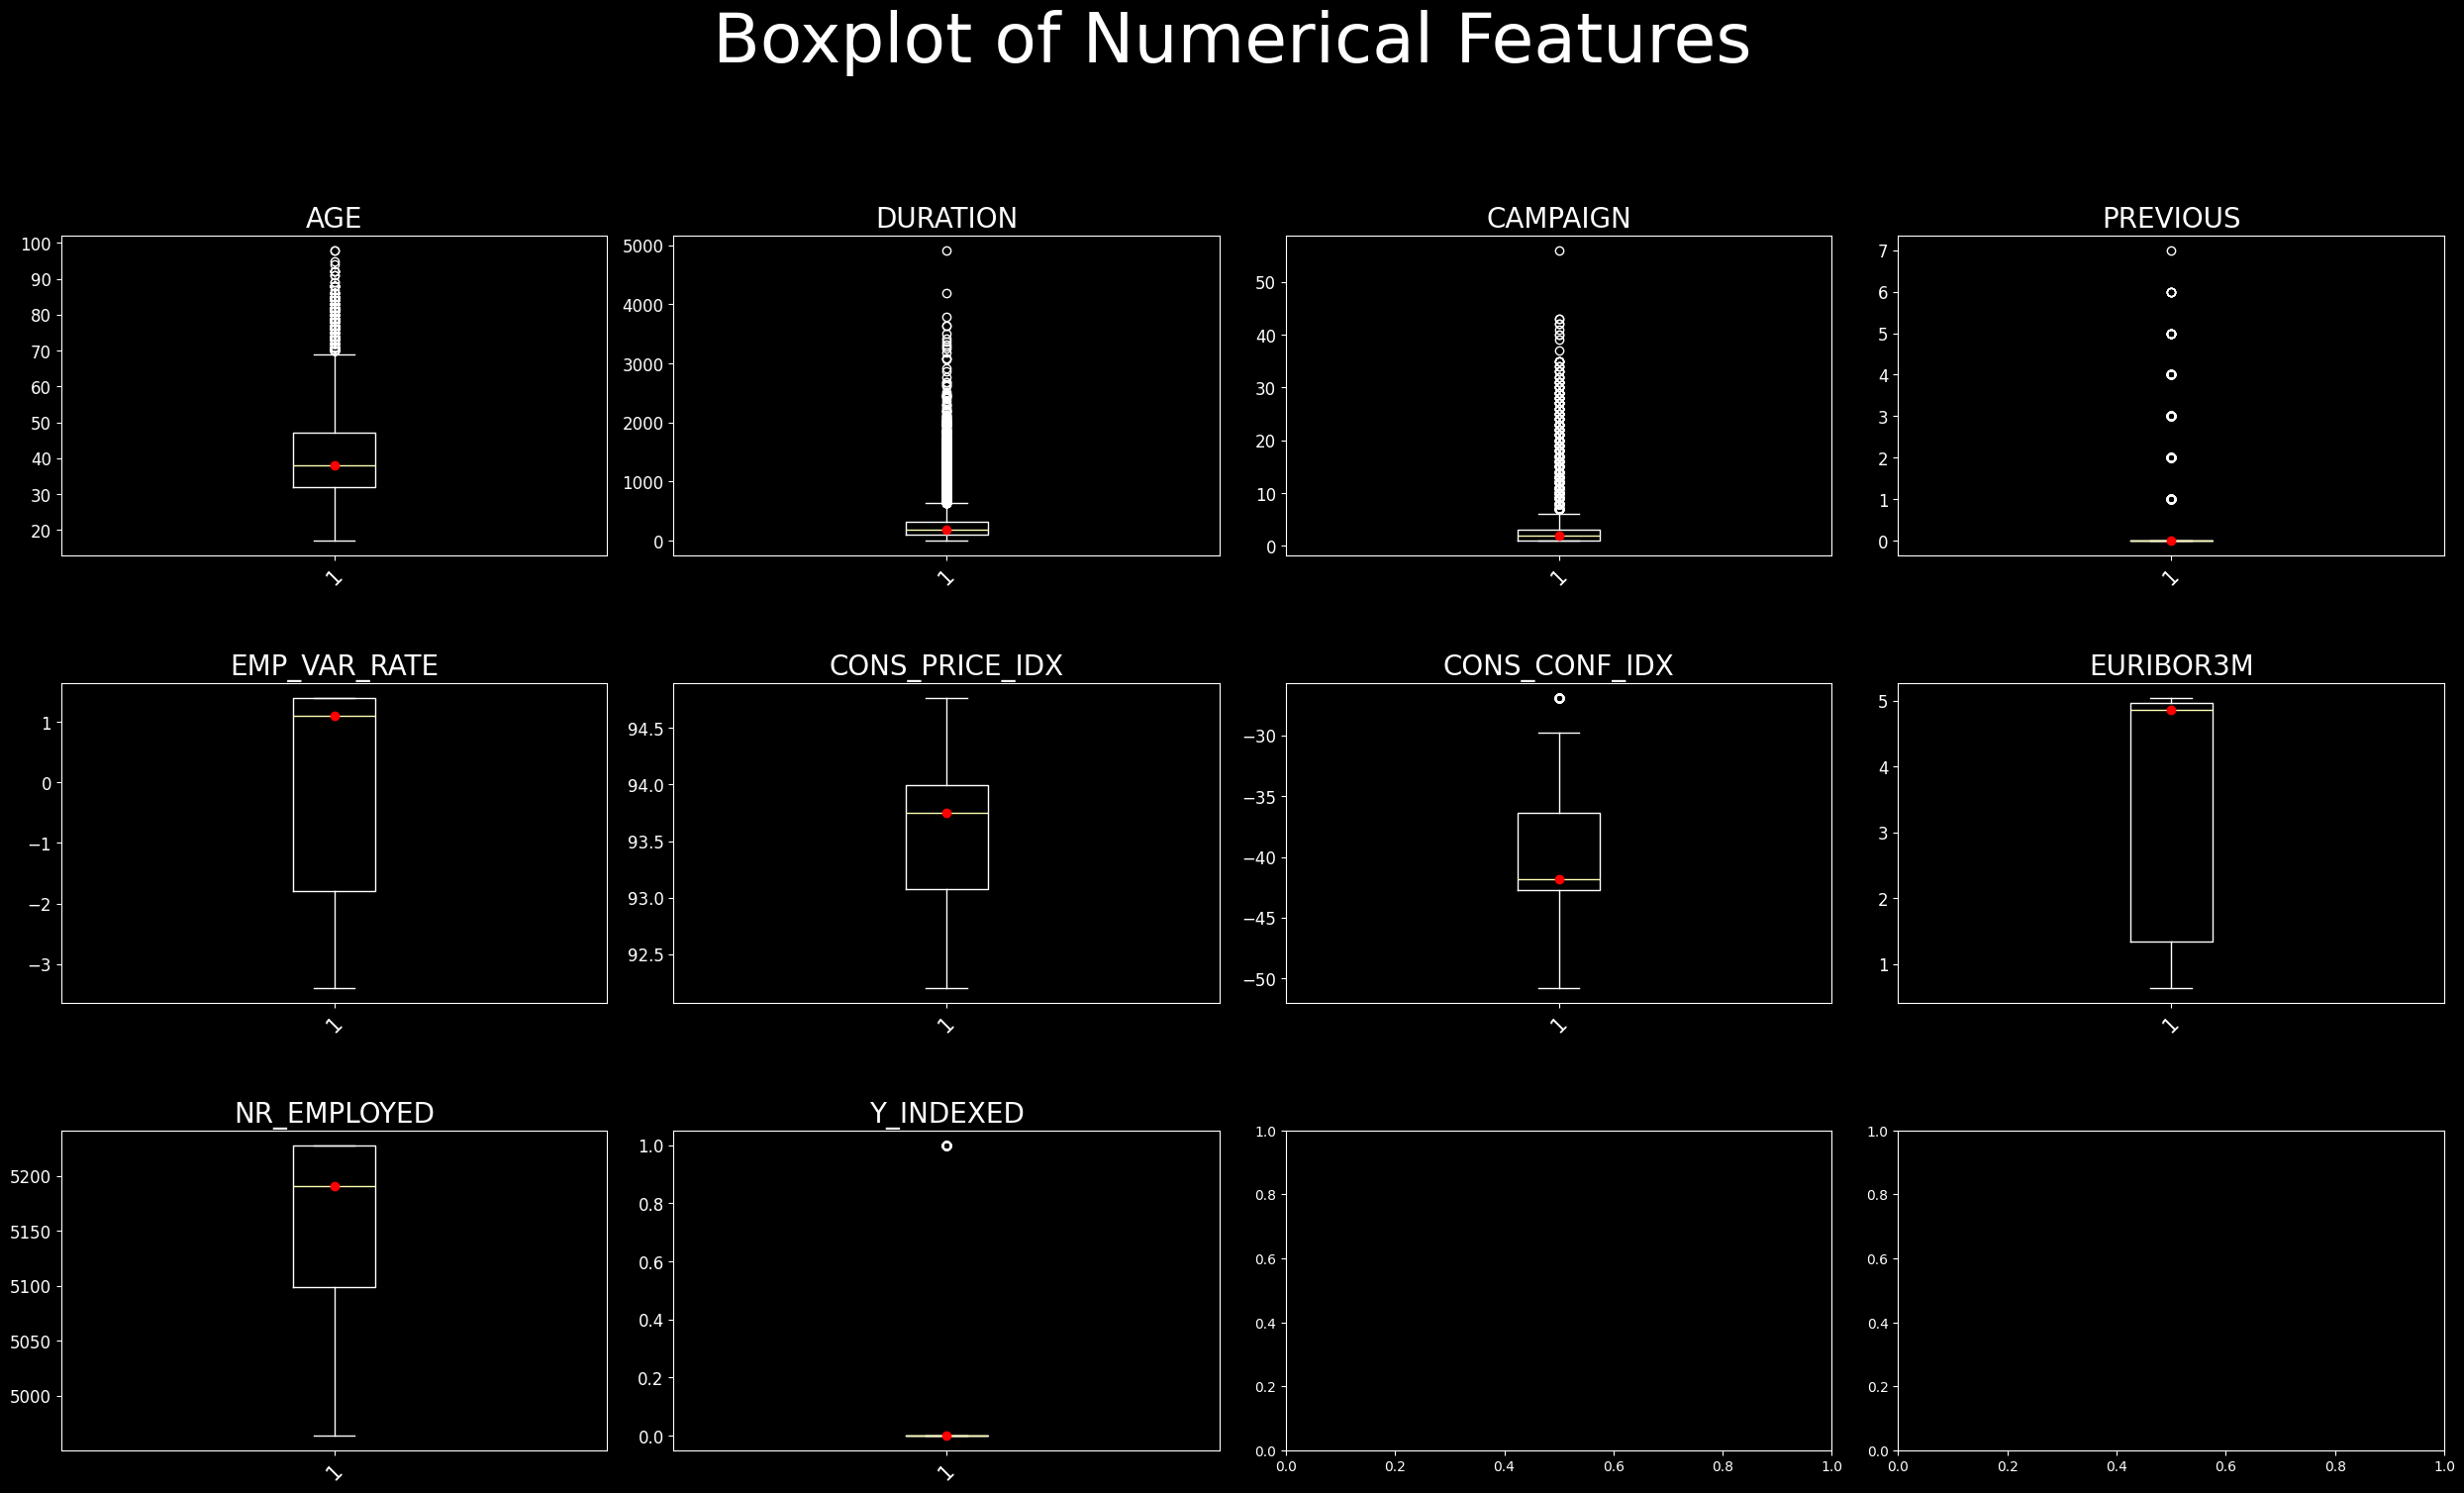

In [23]:
# Assuming scatter_df is a Spark DataFrame
scatter_pd = scatter_df

fig, axes = plt.subplots(3, 4, figsize=(25, 15))
fig.suptitle("Boxplot of Numerical Features", fontsize=50, verticalalignment='center')

for col, ax in zip(scatter_pd.describe().columns, axes.flatten()):
    parts = ax.boxplot(scatter_pd[col])
    
    #for pc in parts['boxes']:
     #   pc.set_facecolor('blue')
      #  pc.set_edgecolor('black')
       # pc.set_alpha(0.7)
    
    medians = ax.scatter(range(1, len(parts['medians']) + 1), [median.get_ydata()[0] for median in parts['medians']], color='red', marker='o', zorder=3)

    ax.set_title(col.upper(), fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()


Consider binning `NR_EMPLOYED` `EMP_VAR_RATE` `EURIBOR3M` to see if improves model accuracy

### Contingency Table

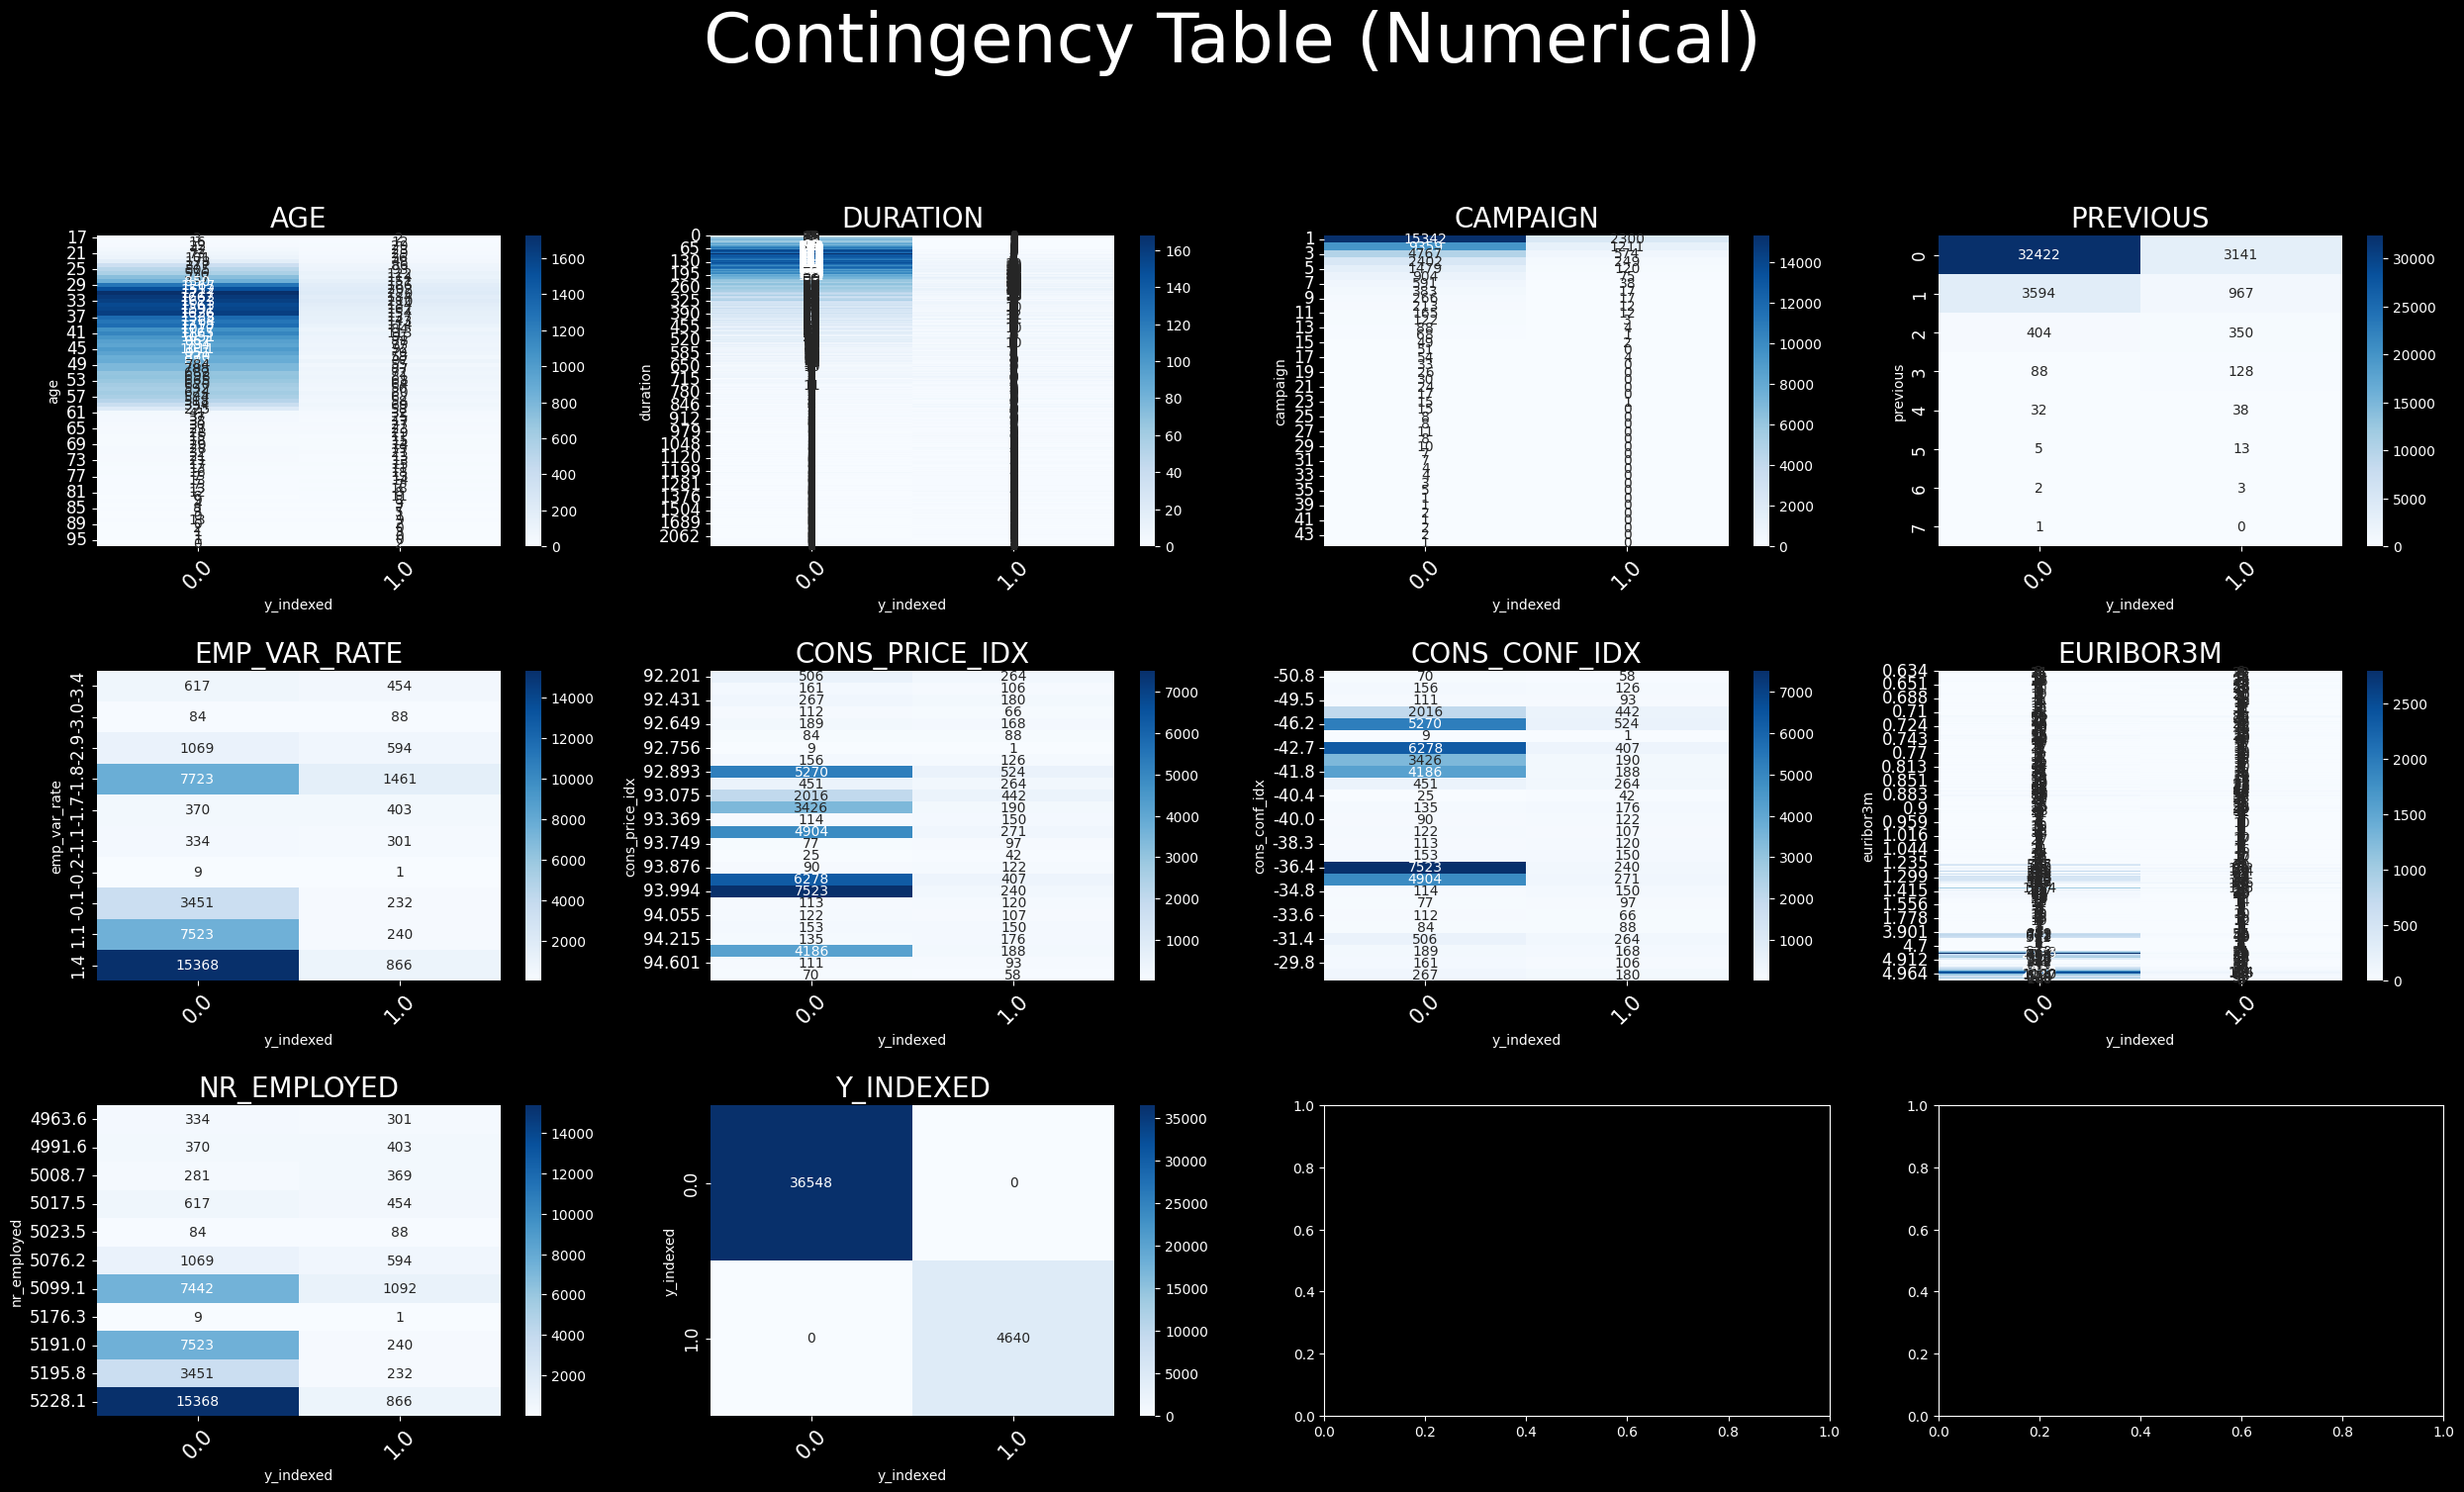

In [24]:
# Assuming scatter_df is a Spark DataFrame
scatter_pd = y_indexed_df.toPandas()

fig, axes = plt.subplots(3, 4, figsize=(25, 15))
fig.suptitle("Contingency Table (Numerical)", fontsize=50, verticalalignment='center')

for col, ax in zip(scatter_pd.describe().columns, axes.flatten()):
    # Create a contingency table
    contingency_table = pd.crosstab(scatter_pd[col], scatter_pd['y_indexed'])
    
    # Plot the contingency table as a heatmap
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=ax)
    
    ax.set_title(col.upper(), fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

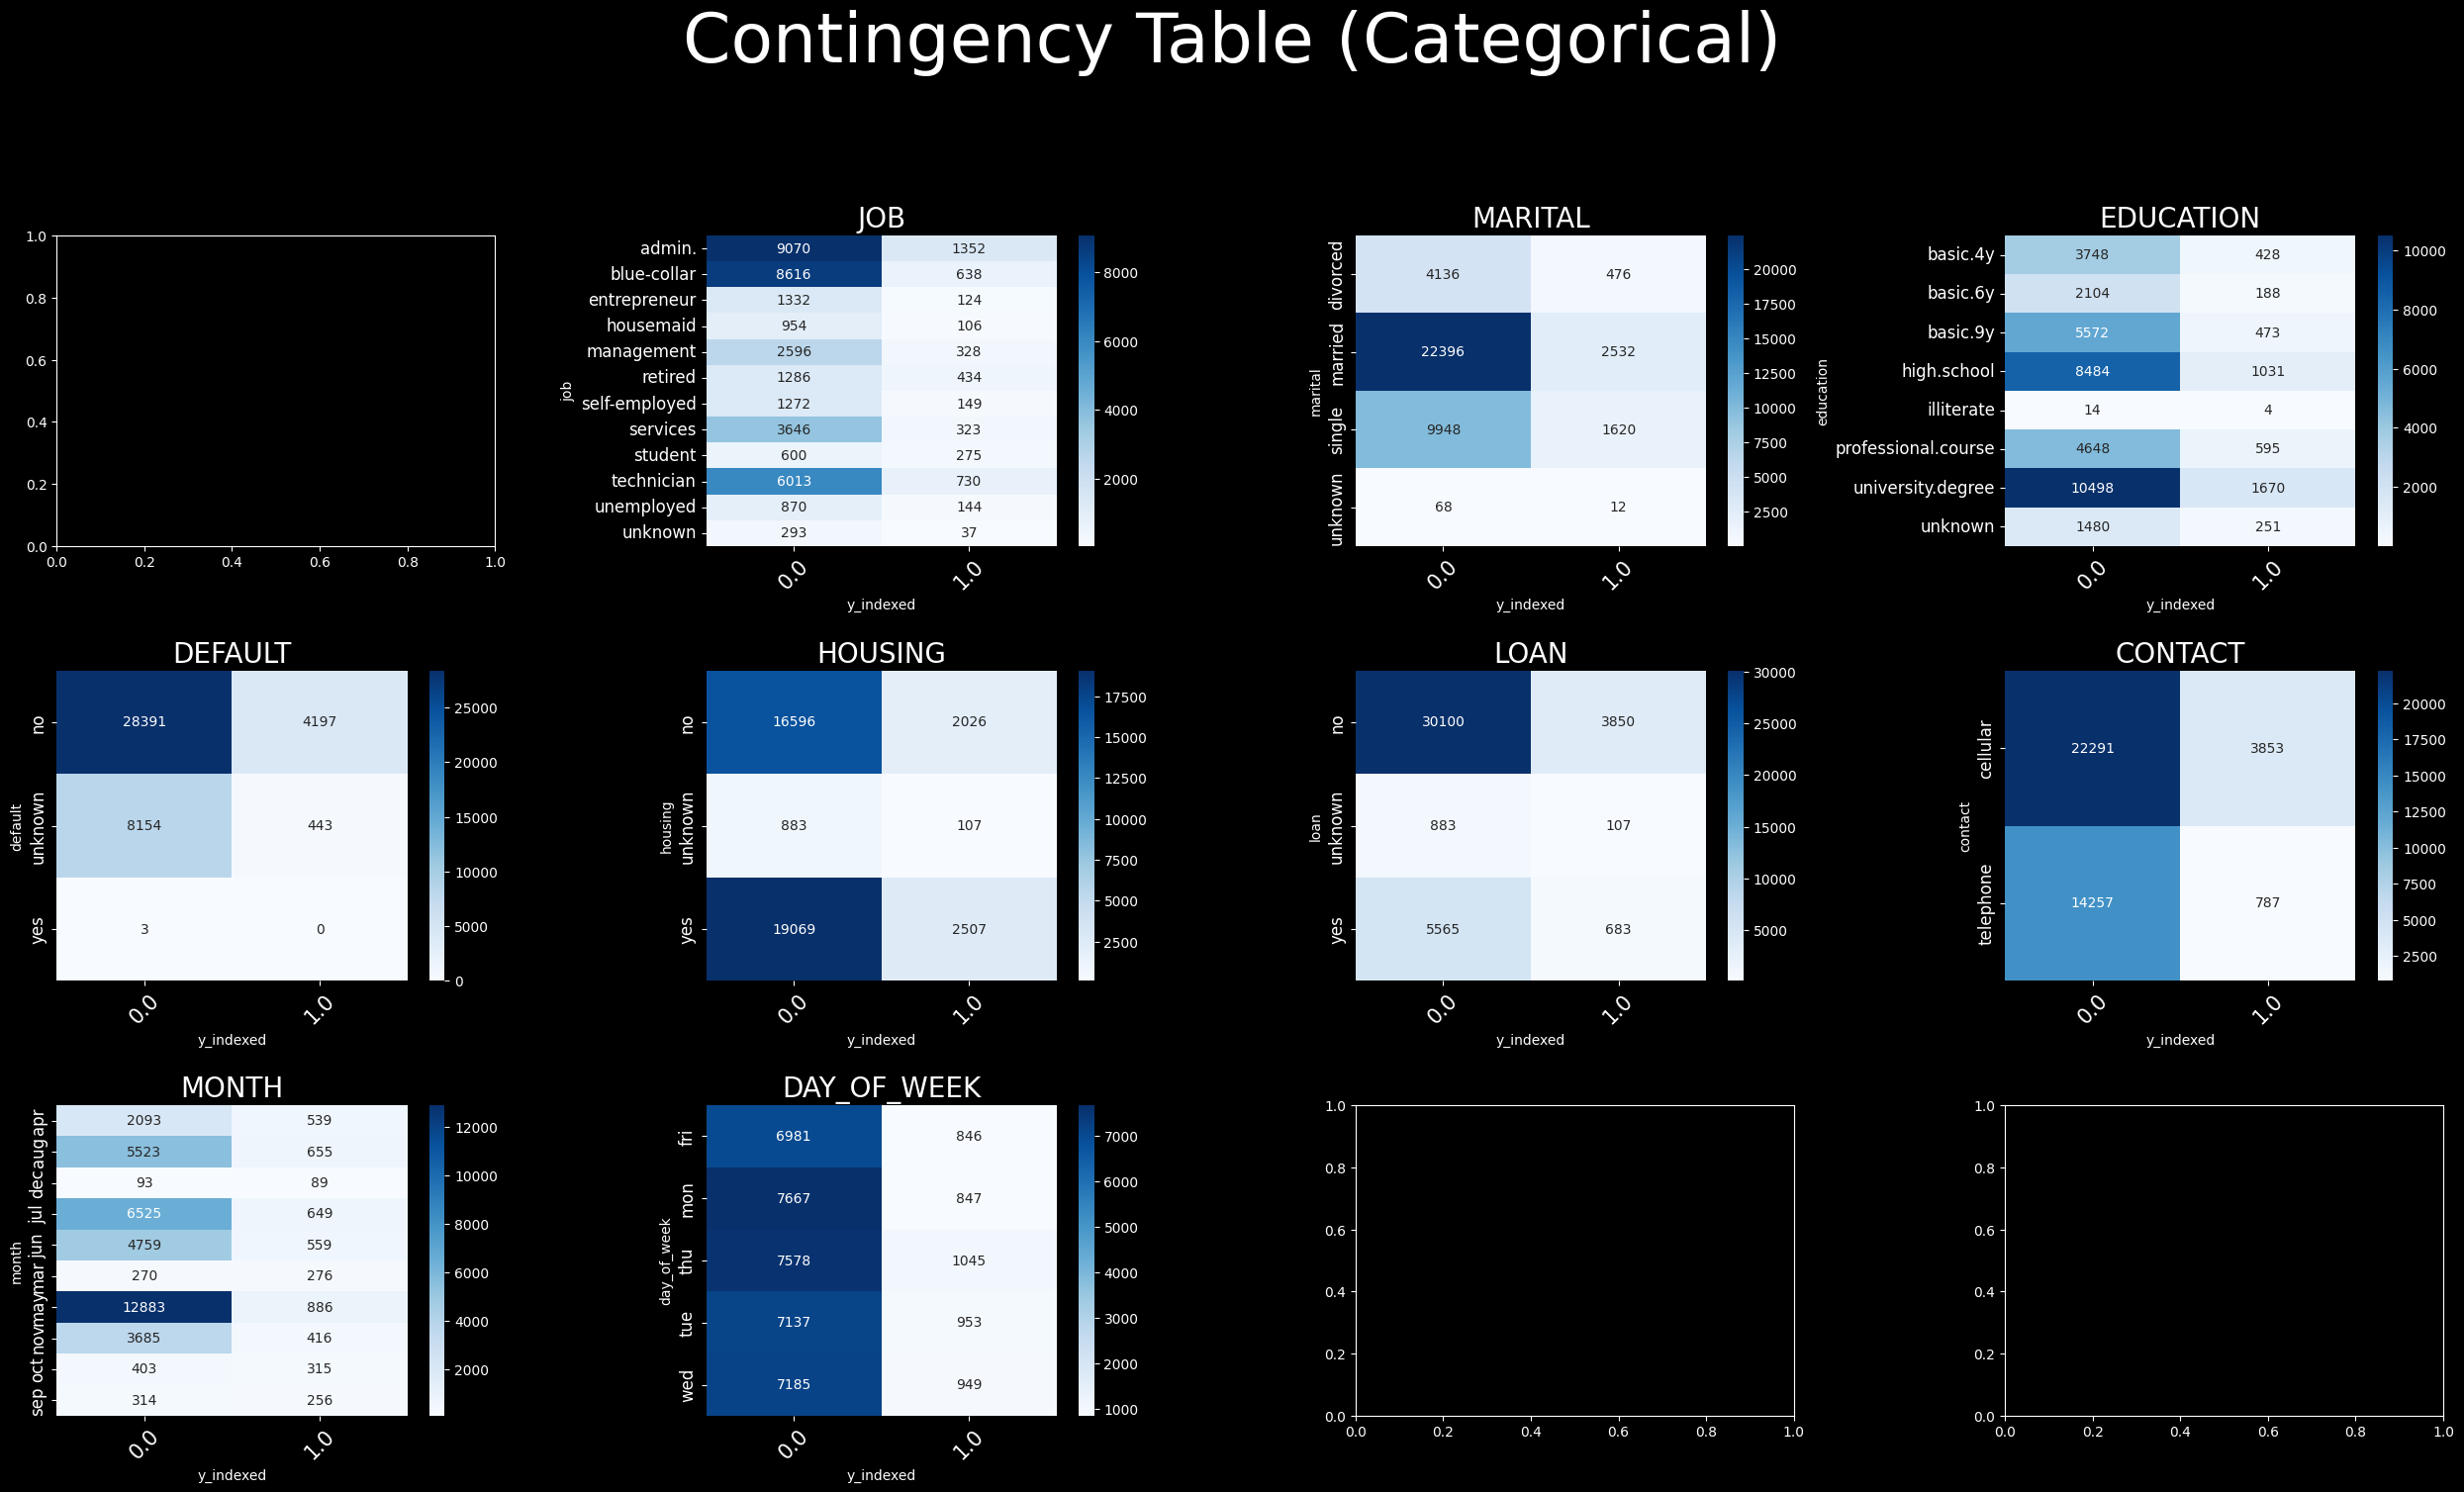

In [25]:
import pandas as pd
import seaborn as sns

# Assuming scatter_df is a Spark DataFrame
scatter_pd = y_indexed_df.toPandas()

fig, axes = plt.subplots(3, 4, figsize=(25, 15))
fig.suptitle("Contingency Table (Categorical)", fontsize=50, verticalalignment='center')

for col, ax in zip(scatter_pd.columns, axes.flatten()):
    # Check if the column is categorical
    if scatter_pd[col].dtype == 'O':  # Assuming 'O' represents object (categorical)
        # Create a contingency table
        contingency_table = pd.crosstab(scatter_pd[col], scatter_pd['y_indexed'])
        
        # Plot the contingency table as a heatmap
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=ax)
        
        ax.set_title(col.upper(), fontsize=20)
        ax.tick_params(axis='x', rotation=45, labelsize=15)
        ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()
#For some reason the new column `PDAYS_Binned` won't display in this code, so have to do it explicitly in next block


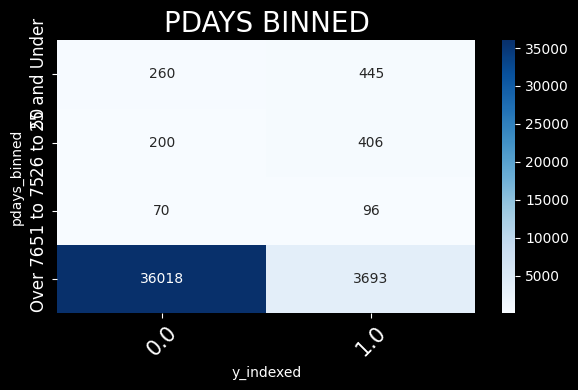

In [26]:
import matplotlib.pyplot as plt

# Assuming scatter_df is a Spark DataFrame
scatter_pd = y_indexed_df.toPandas()

# Create a separate plot for 'Pdays_binned'
fig, ax = plt.subplots(figsize=(6, 4))
contingency_table = pd.crosstab(scatter_pd['pdays_binned'], scatter_pd['y_indexed'])
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('PDAYS BINNED', fontsize=20)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


- ### Develop and save a predictive model to roll out for future use. <br>Explore different techniques and share your findings about the approach and benefits of the champion model.

# Prepare Data for Machine Learning

Determine where indexing/encoding is required...
If binary, LabelEncoder, otherwise StringIndexer/OneHotEncoder
- `default`:    3   SE,OHE
- `month`:  10  SE,OHE
- `education`:  SE,OHE
- `contact`:  LE
- `pdays_binned`: SE,OHE
- `days_of_week`: SE,OHE
- `loan`: SE,OHE
- `y`: LE
- `job`: SE,OHE
- `marital`: SE,OHE
- `housing`: SE,OHE
- `poutcome`: SE,OHE
- I don't know why there are 2 pdays_binned and Pdays_binned columns

In [27]:
categorical_stats_df

,feature,distinct_count,mode,categ_freq
0,job,12,admin.,"[(admin., 10422), (blue-collar, 9254), (technician, 6743), (services, 3969), (management, 2924), (retired, 1720), (entrepreneur, 1456), (self-employed, 1421), (housemaid, 1060), (unemployed, 1014), (student, 875), (unknown, 330)]"
1,default,3,no,"[(no, 32588), (unknown, 8597), (yes, 3)]"
2,marital,4,married,"[(married, 24928), (single, 11568), (divorced, 4612), (unknown, 80)]"
3,day_of_week,5,thu,"[(thu, 8623), (mon, 8514), (wed, 8134), (tue, 8090), (fri, 7827)]"
4,housing,3,yes,"[(yes, 21576), (no, 18622), (unknown, 990)]"
5,education,8,university.degree,"[(university.degree, 12168), (high.school, 9515), (basic.9y, 6045), (professional.course, 5243), (basic.4y, 4176), (basic.6y, 2292), (unknown, 1731), (illiterate, 18)]"
6,poutcome,3,nonexistent,"[(nonexistent, 35563), (failure, 4252), (success, 1373)]"
7,y,2,no,"[(no, 36548), (yes, 4640)]"
8,loan,3,no,"[(no, 33950), (yes, 6248), (unknown, 990)]"
9,contact,2,cellular,"[(cellular, 26144), (telephone, 15044)]"


### Pipeline Method

In [28]:
SE_OH_input = ['default','month', 'education', 'contact','day_of_week', 'loan', 'job', 'marital', 'housing', 'poutcome', 'pdays_binned']
LE_input = ['y']

In [29]:
OHE_output = [ohe + "_OHE" for ohe in SE_OH_input]
VA_input = numeric_features + OHE_output

In [30]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

#Initializes StringIndexer for each feature
stringIndexers = [StringIndexer(inputCol=feature, outputCol=feature + '_SE', handleInvalid="keep") for feature in SE_OH_input]

#Initializes OneHotEncoder for each feature from StringIndexer
encoder = [OneHotEncoder(inputCol=feature+'_SE', outputCol=feature+"_OHE") for feature in SE_OH_input]

assembler = VectorAssembler()\
         .setInputCols (VA_input)\
         .setOutputCol ("vectorized_features")

#Initializes LabelIndexer for each binary features
label_indexer = [StringIndexer(inputCol='y', outputCol='label')]

scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")

In [31]:
df2.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- pdays_binned: string (nullable = true)



In [32]:
df.write.parquet('/Users/nathanzlomke/Downloads/df')

In [33]:
#Protects df
df2=df
#Protects df2
df3 = df2


all_stages = stringIndexers + encoder + [assembler] + label_indexer + [scaler]
pipeline = Pipeline(stages=all_stages)

pipeline_model=pipeline.fit(df2)
pipeline_df=pipeline_model.transform(df3)

23/11/29 13:20:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [34]:
pipeline_df.toPandas().head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,pdays_binned,default_SE,month_SE,education_SE,contact_SE,day_of_week_SE,loan_SE,job_SE,marital_SE,housing_SE,poutcome_SE,pdays_binned_SE,default_OHE,month_OHE,education_OHE,contact_OHE,day_of_week_OHE,loan_OHE,job_OHE,marital_OHE,housing_OHE,poutcome_OHE,pdays_binned_OHE,vectorized_features,label,features
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 76,0.0,0.0,4.0,1.0,1.0,0.0,8.0,0.0,1.0,0.0,0.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(56.0, 261.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)",0.0,"(5.373635610167063, 1.0066366713543708, 0.36100906530306426, 0.0, 0.70020890518682, 162.3833737313782, -7.864832302153638, 2.8003155278245644, 71.84623173414444, 2.460295954302673, 0.0, 0.0, 2.119768460742426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3129425908049335, 0.0, 0.0, 0.0, 0.0, 2.076814714218683, 0.0, 2.4694341891596734, 0.0, 0.0, 0.0, 2.6274608475120544, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.315223743272895, 0.0, 0.0, 0.0, 2.045791845957177, 0.0, 0.0, 0.0, 0.0, 2.0092083707544983, 0.0, 2.912091211204641, 0.0, 0.0, 5.377987301846423, 0.0, 0.0, 0.0)"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 76,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,"(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(57.0, 149.0, 1.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)",0.0,"(5.469593388920046, 0.5746699771333381, 0.36100906530306426, 0.0, 0.70020890518682, 162.3833737313782, -7.864832302153638, 2.8003155278245644, 71.84623173414444, 0.0, 2.4606119305681706, 0.0, 2.119768460742426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.372555799117088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.076814714218683, 0.0, 2.4694341891596734, 0.0, 0.0, 0.0, 2.6274608475120544, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.045791845957177, 0.0, 0.0, 0.0, 0.0, 2.0092083707544983, 0.0, 2.912091211204641, 0.0, 0.0, 5.377987301846423, 0.0, 0.0, 0.0)"


In [35]:
#pipeline_parquet_df = pipeline_df.write.parquet('/Users/nathanzlomke/Downloads/new_output_folder')
#pipeline_parquet_df.('/Users/nathanzlomke/Downloads/KNN_input.csv', index=False)

## Train/Test Split

In [35]:
train, test = pipeline_df.randomSplit([0.8, 0.2], seed = 12345)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32813


Test Dataset Count: 8375


## Logistic Regression Model

In [36]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Assuming 'train' and 'test' are your DataFrames

# Create a Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=5)

# Fit the model on the training data
lrModel = lr.fit(train)

# Make predictions on the test data
lr_predictions = lrModel.transform(test)

# Evaluate precision using BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
precision = binary_evaluator.evaluate(lr_predictions)

# Print the precision
print(f'Precision: {precision}')

# Evaluate accuracy and F1 score using MulticlassClassificationEvaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
accuracy = multiclass_evaluator.evaluate(lr_predictions)

f1_score = multiclass_evaluator.evaluate(lr_predictions, {multiclass_evaluator.metricName: 'f1'})

# Evaluate ROC-AUC using BinaryClassificationEvaluator
roc_auc = binary_evaluator.evaluate(lr_predictions, {binary_evaluator.metricName: 'areaUnderROC'})
print(f'ROC-AUC: {roc_auc}')

# Print accuracy and F1 score
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1_score}')

# Display some predictions
#lr_predictions.select('label', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)


Precision: 0.5960911930543646


ROC-AUC: 0.9354829801542436
Accuracy: 0.909134328358209
F1 Score: 0.9009959638561371


### Confusion Matrix

In [38]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 403  537]
 [ 224 7211]]


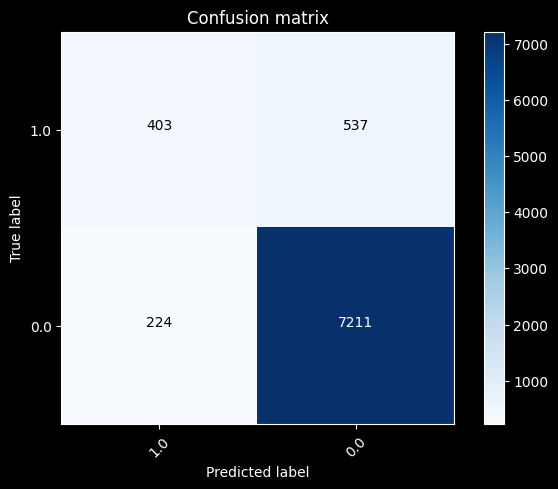

In [39]:
y_true = lr_predictions.select("label")
y_true = y_true.toPandas()

y_pred_lr = lr_predictions.select("prediction")
y_pred_lr = y_pred_lr.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred_lr,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

### Accuracy

In [40]:
#accuracy = lr_predictions.filter(lr_predictions.label == lr_predictions.prediction).count() / float(lr_predictions.count())
#print("Accuracy : ",accuracy)

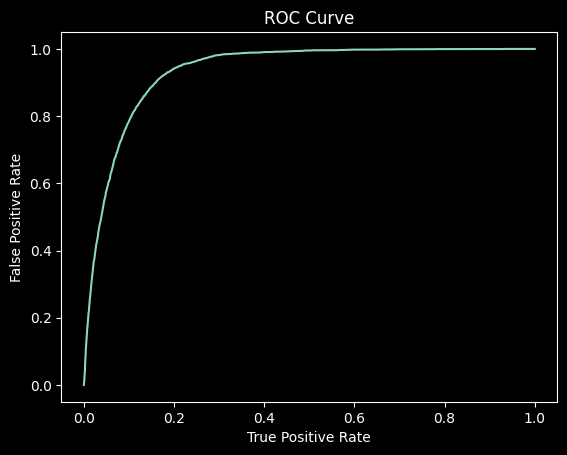

Training set areaUnderROC: 0.9342352120952774


In [41]:
trainingSummary = lrModel.summary
lr_roc = trainingSummary.roc.toPandas()
plt.plot(lr_roc['FPR'],lr_roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

# Gradient Boosting

In [41]:
from pyspark.ml.classification import GBTClassifier

# Assuming 'train' and 'test' are your DataFrames

# Create a Logistic Regression model
gb = GBTClassifier(featuresCol='features', labelCol='label', maxIter=5)

# Fit the model on the training data
gbModel = gb.fit(train)

# Make predictions on the test data
gb_predictions = gbModel.transform(test)

# Evaluate precision using BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
precision = binary_evaluator.evaluate(gb_predictions)

# Print the precision
print(f'Precision: {precision}')

# Evaluate accuracy and F1 score using MulticlassClassificationEvaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
accuracy = multiclass_evaluator.evaluate(gb_predictions)

f1_score = multiclass_evaluator.evaluate(gb_predictions, {multiclass_evaluator.metricName: 'f1'})

# Evaluate ROC-AUC using BinaryClassificationEvaluator
roc_auc = binary_evaluator.evaluate(gb_predictions, {binary_evaluator.metricName: 'areaUnderROC'})
print(f'ROC-AUC: {roc_auc}')

# Print accuracy and F1 score
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1_score}')

# Display some predictions
#lr_predictions.select('label', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)


Precision: 0.6428895333325575


ROC-AUC: 0.9393023937958762
Accuracy: 0.9143880597014925
F1 Score: 0.90962741642109


Confusion matrix, without normalization
[[ 477  463]
 [ 254 7181]]


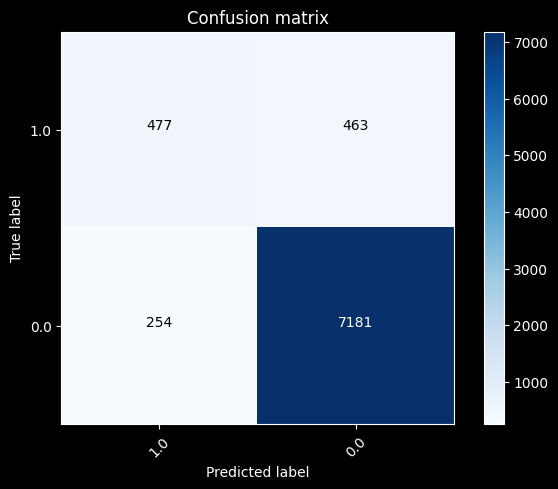

In [42]:
y_true = gb_predictions.select("label")
y_true = y_true.toPandas()

y_pred_gb = gb_predictions.select("prediction")
y_pred_gb = y_pred_gb.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred_gb,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

# Random Forest

In [43]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Assuming 'train' and 'test' are your DataFrames

# Create a Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', maxDepth=5, numTrees=10)

# Fit the model on the training data
rfModel = rf.fit(train)

# Make predictions on the test data
rf_predictions = rfModel.transform(test)

# Evaluate precision using BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
precision = binary_evaluator.evaluate(rf_predictions)

# Print the precision
print(f'Precision: {precision}')

# Evaluate accuracy and F1 score using MulticlassClassificationEvaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
accuracy = multiclass_evaluator.evaluate(rf_predictions)

f1_score = multiclass_evaluator.evaluate(rf_predictions, {multiclass_evaluator.metricName: 'f1'})

# Evaluate ROC-AUC using BinaryClassificationEvaluator
roc_auc = binary_evaluator.evaluate(rf_predictions, {binary_evaluator.metricName: 'areaUnderROC'})
print(f'ROC-AUC: {roc_auc}')

# Print accuracy and F1 score
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1_score}')

# Display some predictions
# rf_predictions.select('label', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)


Precision: 0.5720267170742286


ROC-AUC: 0.9134871009744022
Accuracy: 0.9032835820895523
F1 Score: 0.8788273128577477


Confusion matrix, without normalization
[[ 202  738]
 [  72 7363]]


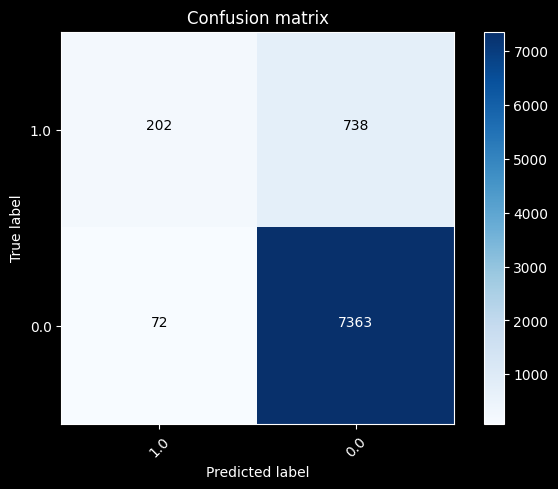

In [44]:
y_true = rf_predictions.select("label")
y_true = y_true.toPandas()

y_pred_rf = rf_predictions.select("prediction")
y_pred_rf = y_pred_rf.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred_rf,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

# Decision Tree

In [45]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Assuming 'train' and 'test' are your DataFrames

# Create a Decision Tree model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=5)

# Fit the model on the training data
dtModel = dt.fit(train)

# Make predictions on the test data
dt_predictions = dtModel.transform(test)

# Evaluate precision using BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
precision = binary_evaluator.evaluate(dt_predictions)

# Print the precision
print(f'Precision: {precision}')

# Evaluate accuracy and F1 score using MulticlassClassificationEvaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
accuracy = multiclass_evaluator.evaluate(dt_predictions)

f1_score = multiclass_evaluator.evaluate(dt_predictions, {multiclass_evaluator.metricName: 'f1'})

# Evaluate ROC-AUC using BinaryClassificationEvaluator
roc_auc = binary_evaluator.evaluate(dt_predictions, {binary_evaluator.metricName: 'areaUnderROC'})
print(f'ROC-AUC: {roc_auc}')

# Print accuracy and F1 score
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1_score}')

# Display some predictions
# dt_predictions.select('label', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)


Precision: 0.4986422569593676


ROC-AUC: 0.7988646997381561
Accuracy: 0.9135522388059701
F1 Score: 0.9082394537610923


Confusion matrix, without normalization
[[ 464  476]
 [ 248 7187]]


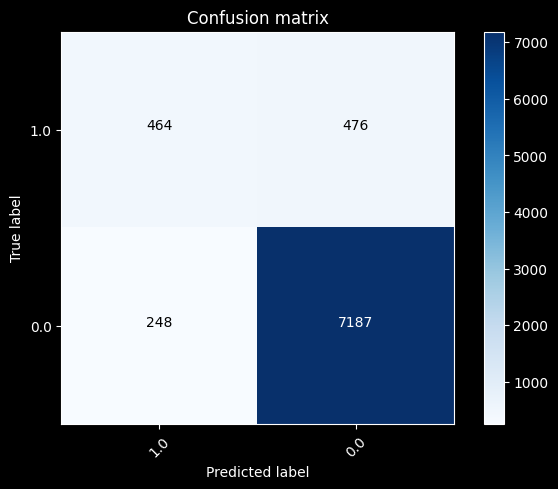

In [46]:
y_true = dt_predictions.select("label")
y_true = y_true.toPandas()

y_pred_dt = dt_predictions.select("prediction")
y_pred_dt = y_pred_dt.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred_dt,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

## Best Model:  Gradient Boosting

### Best Model Performance

### Best Model Feature Weights

In [47]:
feature_importances = gbModel.featureImportances
feature_importance_df = sqlContext.createDataFrame([(feature, float(importance)) for feature, importance in zip(assembler.getInputCols(), feature_importances)], ["Feature", "Importance"])
#feature_importance_df = feature_importance_df.toPandas()
feature_importance_df


DataFrame[Feature: string, Importance: double]

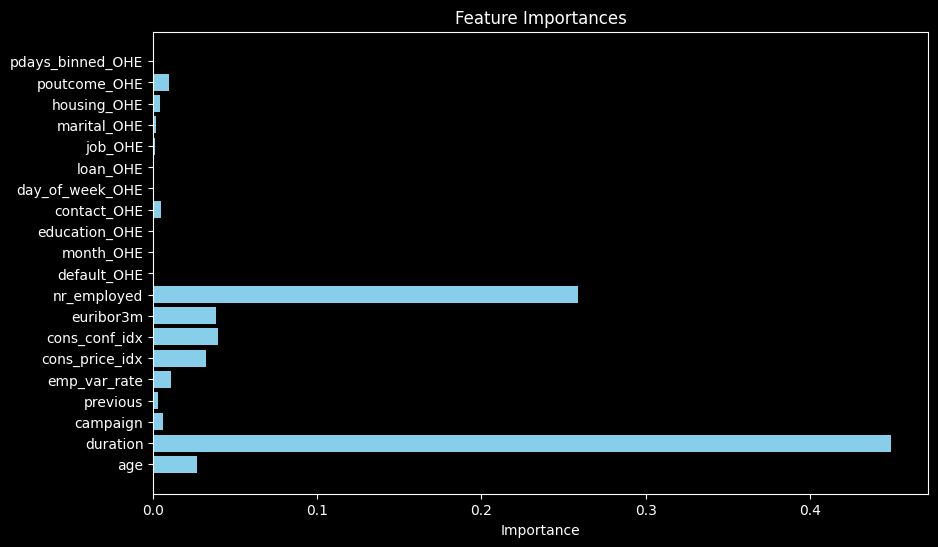

In [48]:
import matplotlib.pyplot as plt

# Extract feature names and importances as lists
features = feature_importance_df.select("Feature").rdd.flatMap(lambda x: x).collect()
importances = feature_importance_df.select("Importance").rdd.flatMap(lambda x: x).collect()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


#### Top 10
- Duration
- nr_employed
- euribor3m
- cons_conf_idx
- age
- cons_price_idx
- education_OHE
- housing_OHE
- emp_var_rate
- campaign

### Best Model Parameters

In [49]:

# Model summary (if available)
tree_structure = print(gbModel._java_obj.toDebugString())

GBTClassificationModel: uid = GBTClassifier_96c9f70a8877, numTrees=5, numClasses=2, numFeatures=66
  Tree 0 (weight 1.0):
    If (feature 8 <= 70.41581215222885)
     If (feature 1 <= 0.6383079276212581)
      If (feature 61 <= 2.7853309667905366)
       If (feature 1 <= 0.4300382714789745)
        If (feature 1 <= 0.2989055250190181)
         Predict: -0.98
        Else (feature 1 > 0.2989055250190181)
         Predict: -0.8005540166204986
       Else (feature 1 > 0.4300382714789745)
        If (feature 5 <= 162.00243948123705)
         Predict: -0.4841628959276018
        Else (feature 5 > 162.00243948123705)
         Predict: -0.8582677165354331
      Else (feature 61 > 2.7853309667905366)
       If (feature 33 <= 1.2347170945798367)
        If (feature 28 <= 2.491867072621435)
         Predict: -0.14685314685314685
        Else (feature 28 > 2.491867072621435)
         Predict: 1.0
       Else (feature 33 > 1.2347170945798367)
        If (feature 43 <= 1.6943867109997708)
         

# Saving models as serialized objects

### First, pickle the preprocessing pipeline

In [ ]:
# Save the pipeline model
ppl_pickle_model = pipeline_model
ppl_pickle_model=pipeline.fit(df)
ppl_pickle_model.write().overwrite().save("/Users/nathanzlomke/Downloads/preprocessing_pipeline")


### Load in preprocessing pipeline and use script to create df in PySpark ML format

In [ ]:
ppl_pickle_model = ppl_pickle_model.load("/Users/nathanzlomke/Downloads/preprocessing_pipeline")
ppl_pickle_df=ppl_pickle_model.transform(df)

#### Pickled Logistic Regression

In [ ]:
lr_pickle_model = LogisticRegression(featuresCol='features', labelCol='label', maxIter=5)

# Trained model on pipeline df
lr_pickle = lr_pickle_model.fit(ppl_pickle_df)
lr_pickle.write().overwrite().save("/Users/nathanzlomke/Downloads/lr_pickle")

Testing it...

In [ ]:
lr_pipelineModel = lr_pickle.load("/Users/nathanzlomke/Downloads/lr_pickle")
predictions = lr_pipelineModel.transform(ppl_pickle_df)

#### Pickled Gradient Boosting Model

In [51]:
from pyspark.ml.classification import GBTClassifier
gb_pickle_model = GBTClassifier(featuresCol='features', labelCol='label', maxIter=5)

# Trained model on pipeline df
gb_pickle = gb_pickle_model.fit(ppl_pickle_df)
gb_pickle.write().overwrite().save("/Users/nathanzlomke/Downloads/winner_gb_pickle")

#### Pickled Random Forest Model

In [52]:
from pyspark.ml.classification import RandomForestClassifier
rf_pickle_model = RandomForestClassifier(featuresCol='features', labelCol='label', maxDepth=5, numTrees=10)

# Trained model on pipeline df
rf_pickle = rf_pickle_model.fit(ppl_pickle_df)
rf_pickle.write().overwrite().save("/Users/nathanzlomke/Downloads/rf_pickle")

#### Pickled Decision Tree Model

In [53]:
from pyspark.ml.classification import DecisionTreeClassifier
dt_pickle_model = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=5)

# Trained model on pipeline df
dt_pickle = dt_pickle_model.fit(ppl_pickle_df)
dt_pickle.write().overwrite().save("/Users/nathanzlomke/Downloads/dt_pickle")

23/11/29 22:03:49 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 17870400 ms exceeds timeout 120000 ms
23/11/29 22:03:49 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/29 22:03:49 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 64626)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/nathanzlomke/Documents/spark-3.3.3-bin-hadoop3/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/Users/nathanzlomke/Documents/spark-3.3.3-bin-hado

To explain, to deploy the models, the user will first need to use the preprocessing pipeline and associated script: <br>
`ppl_pickle_df=ppl_pickle_model.transform(df)` to convert features into PySpark ML context<br>
and for naming conventions to reference correctly

# Export Top10 df for Kmeans clustering in separate notebook

In [50]:
top10 = pipeline_df.select('Duration', 'nr_employed', 'euribor3m', 'cons_conf_idx', 'age', 
                           'cons_price_idx', 'education_OHE', 'housing_OHE', 'emp_var_rate', 'campaign')
top10.columns

['Duration',
 'nr_employed',
 'euribor3m',
 'cons_conf_idx',
 'age',
 'cons_price_idx',
 'education_OHE',
 'housing_OHE',
 'emp_var_rate',
 'campaign']

In [61]:
top10_wTarget = pipeline_df.select('Duration', 'nr_employed', 'euribor3m', 'cons_conf_idx', 'age', 
                           'cons_price_idx', 'education_OHE', 'housing_OHE', 'emp_var_rate', 'campaign', 'y')


### Export df to parquet for use in Kmeans clustering

In [62]:
top10.write.parquet('/Users/nathanzlomke/Downloads/output', mode='overwrite')
top10_wTarget.write.parquet('/Users/nathanzlomke/Downloads/output_wTarget', mode='overwrite')


In [63]:
top10_wTarget.toPandas().head()

,Duration,nr_employed,euribor3m,cons_conf_idx,age,cons_price_idx,education_OHE,housing_OHE,emp_var_rate,campaign,y
0,261,5191.0,4.857,-36.4,56,93.994,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,no
1,149,5191.0,4.857,-36.4,57,93.994,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,no
2,226,5191.0,4.857,-36.4,37,93.994,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",1.1,1,no
3,151,5191.0,4.857,-36.4,40,93.994,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,no
4,307,5191.0,4.857,-36.4,56,93.994,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)",1.1,1,no
